In [1]:
import copy
import os
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchview import draw_graph
from torchvision import datasets, transforms
from torchvision.models import ResNet34_Weights, resnet34
from torchvision.utils import make_grid
from sklearn.metrics import f1_score

train: 40000 images across 10 classes
val: 10000 images across 10 classes
test: 10000 images across 10 classes
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Loaded batch shapes: torch.Size([32, 3, 224, 224]) torch.Size([32])


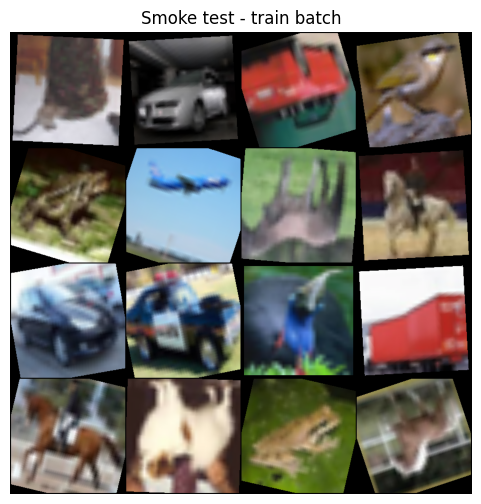

In [2]:
# point to the local CIFAR-10 batch folder present in the repo
DATA_ROOT = Path("cifar-10-batches-py")
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def create_dataloaders(data_root: Path,
                       batch_size: int = BATCH_SIZE,
                       img_size: int = IMG_SIZE,
                       num_workers: int = NUM_WORKERS,
                       val_split: float = 0.2):
    """Create dataloaders for CIFAR-10 (raw batch files) or fallback to ImageFolder layout."""
    data_root = Path(data_root)
    if not data_root.exists():
        raise FileNotFoundError(f"Dataset root not found: {data_root.resolve()}")

    # transforms resize CIFAR images to IMG_SIZE so pretrained ResNet34 can be used
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomAffine(degrees=20, scale=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    eval_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    # detect CIFAR-10 batch folder (this repo contains cifar-10-batches-py)
    cifar_folder = None
    if (data_root / "cifar-10-batches-py").exists():
        # torchvision expects the parent folder to store CIFAR files
        cifar_folder = str(data_root)
    elif data_root.name == "cifar-10-batches-py" and data_root.exists():
        cifar_folder = str(data_root.parent)
    elif (data_root / "data_batch_1").exists() or (data_root / "test_batch").exists():
        cifar_folder = str(data_root)

    datasets_map = {}

    if cifar_folder is not None:
        # load CIFAR-10 using torchvision (no download; expects batch files present)
        full_train = datasets.CIFAR10(cifar_folder, train=True, transform=train_transforms, download=False)
        test_ds = datasets.CIFAR10(cifar_folder, train=False, transform=eval_transforms, download=False)

        # create validation split from training set
        val_size = int(len(full_train) * val_split)
        train_size = len(full_train) - val_size
        if val_size <= 0:
            train_ds = full_train
            val_ds = None
        else:
            train_ds, val_ds = torch.utils.data.random_split(full_train, [train_size, val_size],
                                                       generator=torch.Generator().manual_seed(42))

        datasets_map["train"] = train_ds
        if val_ds is not None:
            datasets_map["val"] = val_ds
        datasets_map["test"] = test_ds

        classes = full_train.classes
    else:
        # fallback: expect ImageFolder layout under data_root/train and data_root/val
        train_folder = data_root / "train"
        val_folder = data_root / "val"
        if not train_folder.exists() or not val_folder.exists():
            raise FileNotFoundError("Expected either CIFAR-10 batch files (cifar-10-batches-py) or an ImageFolder layout with 'train' and 'val' directories.")
        datasets_map = {
            "train": datasets.ImageFolder(root=train_folder, transform=train_transforms),
            "val": datasets.ImageFolder(root=val_folder, transform=eval_transforms),
        }
        if (data_root / "test").exists():
            datasets_map["test"] = datasets.ImageFolder(root=data_root / "test", transform=eval_transforms)
        classes = datasets_map["train"].classes

    dataloaders = {
        split: DataLoader(ds,
                          batch_size=batch_size,
                          shuffle=(split == "train"),
                          num_workers=num_workers,
                          pin_memory=torch.cuda.is_available())
        for split, ds in datasets_map.items()
    }

    return dataloaders, classes


# create dataloaders (will detect local cifar-10-batches-py if present)
dataloaders, class_names = create_dataloaders(DATA_ROOT)

for split, loader in dataloaders.items():
    try:
        n = len(loader.dataset)
    except Exception:
        # Subset may not implement len reliably in some edge cases; fall back to 0
        n = getattr(loader.dataset, "__len__", lambda: 0)()
    print(f"{split}: {n} images across {len(class_names)} classes")

print(f"Classes: {class_names}")

# Defaults for training (used later in notebook)
EPOCHS = globals().get('EPOCHS', 5)
LEARNING_RATE = globals().get('LEARNING_RATE', 1e-3)

# Quick smoke-test: load one batch and display a grid
try:
    batch = next(iter(dataloaders['train']))
    images, labels = batch
    print('Loaded batch shapes:', images.shape, labels.shape)

    # unnormalize and show grid (may be redundant with later visualizer)
    imgs = images[:16].detach().cpu()
    mean = torch.tensor(IMAGENET_MEAN).view(-1, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(-1, 1, 1)
    imgs = imgs * std + mean
    grid = make_grid(imgs, nrow=4, padding=2)
    np_img = grid.permute(1, 2, 0).numpy().clip(0, 1)
    plt.figure(figsize=(6, 6))
    plt.imshow(np_img)
    plt.axis('off')
    plt.title('Smoke test - train batch')
    plt.show()
except Exception as e:
    print('Smoke test failed:', e)

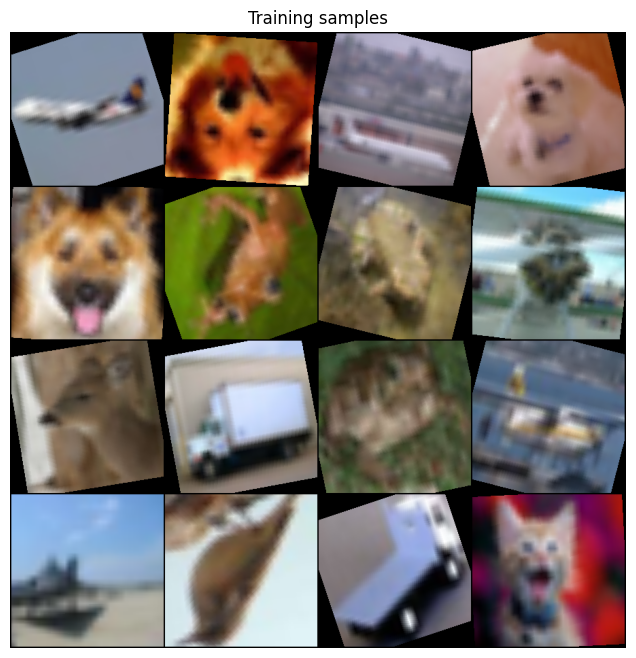

In [3]:
def visualize_batch(dataloader, n_images: int = 16, title: Optional[str] = None):
    """Display a grid of images from a dataloader batch."""
    if n_images < 1:
        raise ValueError("n_images must be at least 1")

    images, labels = next(iter(dataloader))
    n_images = min(n_images, images.size(0))
    images = images[:n_images].detach().cpu()

    mean = torch.tensor(IMAGENET_MEAN).view(-1, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(-1, 1, 1)
    images = images * std + mean

    grid = make_grid(images, nrow=int(n_images**0.5) or 1, padding=2)
    np_img = grid.permute(1, 2, 0).numpy().clip(0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(title or "Sample batch")
    plt.show()


visualize_batch(dataloaders["train"], title="Training samples")


TRAIN split - Class distribution:
Class           Count      Percentage  
----------------------------------------
airplane        4027        10.07%
automobile      3990         9.98%
bird            3994         9.98%
cat             4033        10.08%
deer            4037        10.09%
dog             3976         9.94%
frog            3975         9.94%
horse           3965         9.91%
ship            4002        10.01%
truck           4001        10.00%

Total: 40000 images
✓ Dataset is BALANCED (max deviation: 0.92%)


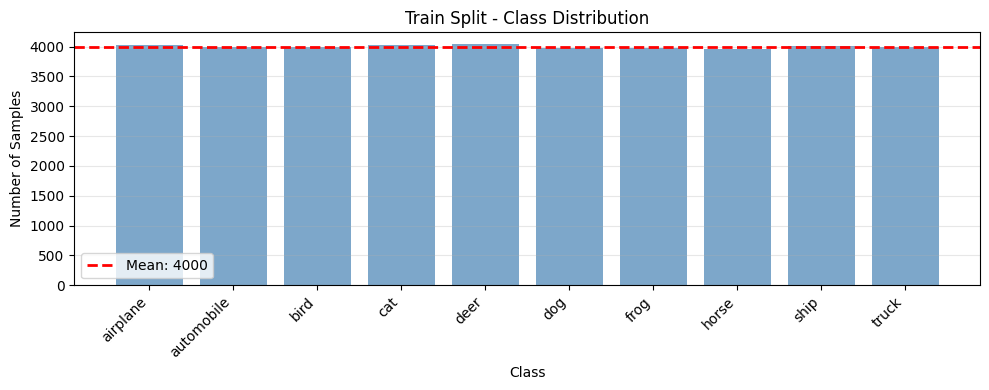


VAL split - Class distribution:
Class           Count      Percentage  
----------------------------------------
airplane        973          9.73%
automobile      1010        10.10%
bird            1006        10.06%
cat             967          9.67%
deer            963          9.63%
dog             1024        10.24%
frog            1025        10.25%
horse           1035        10.35%
ship            998          9.98%
truck           999          9.99%

Total: 10000 images
✓ Dataset is BALANCED (max deviation: 3.70%)


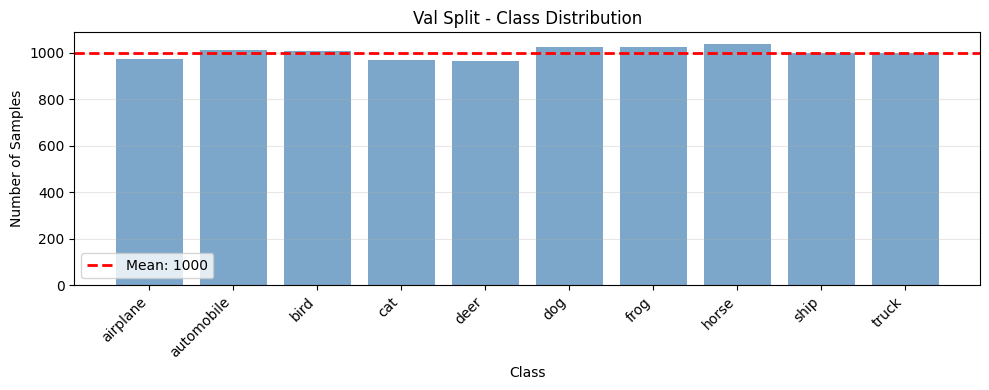


TEST split - Class distribution:
Class           Count      Percentage  
----------------------------------------
airplane        1000        10.00%
automobile      1000        10.00%
bird            1000        10.00%
cat             1000        10.00%
deer            1000        10.00%
dog             1000        10.00%
frog            1000        10.00%
horse           1000        10.00%
ship            1000        10.00%
truck           1000        10.00%

Total: 10000 images
✓ Dataset is BALANCED (max deviation: 0.00%)


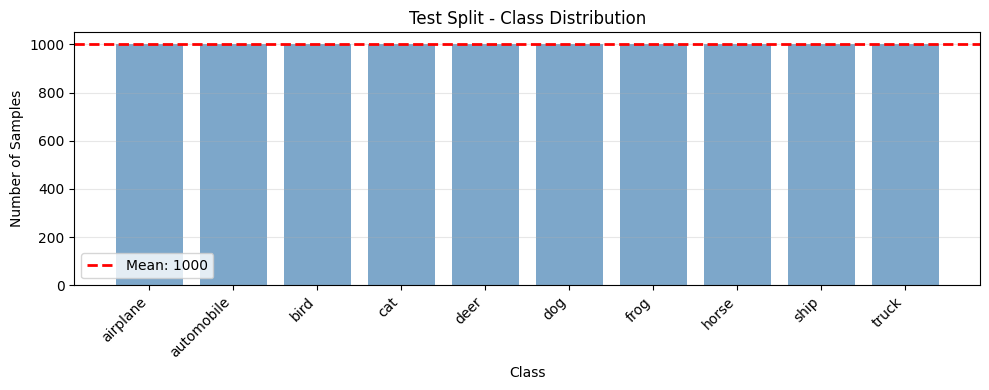

In [4]:
# Add this as a new cell after the dataloader creation cell

# Check class balance in the dataset
from collections import Counter

def check_class_balance(dataloaders: dict, class_names: list):
    """Check and visualize class distribution across splits."""
    for split, loader in dataloaders.items():
        # Collect all labels from the dataset
        all_labels = []
        dataset = loader.dataset
        
        # Handle both Dataset and Subset (from random_split)
        if hasattr(dataset, 'dataset'):
            # It's a Subset from random_split
            base_dataset = dataset.dataset
            indices = dataset.indices
            if hasattr(base_dataset, 'targets'):
                all_labels = [base_dataset.targets[i] for i in indices]
            elif hasattr(base_dataset, 'labels'):
                all_labels = [base_dataset.labels[i] for i in indices]
        else:
            # It's a direct Dataset (CIFAR10 or ImageFolder)
            if hasattr(dataset, 'targets'):
                all_labels = dataset.targets
            elif hasattr(dataset, 'labels'):
                all_labels = dataset.labels
        
        # Count occurrences
        if all_labels:
            label_counts = Counter(all_labels)
            total = len(all_labels)
            
            print(f"\n{split.upper()} split - Class distribution:")
            print(f"{'Class':<15} {'Count':<10} {'Percentage':<12}")
            print("-" * 40)
            
            for class_idx in sorted(label_counts.keys()):
                count = label_counts[class_idx]
                percentage = (count / total) * 100
                class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
                print(f"{class_name:<15} {count:<10} {percentage:>6.2f}%")
            
            print(f"\nTotal: {total} images")
            
            # Check if balanced (variance < 5% from mean)
            counts = list(label_counts.values())
            mean_count = sum(counts) / len(counts)
            max_deviation = max(abs(c - mean_count) / mean_count * 100 for c in counts)
            
            if max_deviation < 5:
                print(f"✓ Dataset is BALANCED (max deviation: {max_deviation:.2f}%)")
            else:
                print(f"⚠ Dataset is IMBALANCED (max deviation: {max_deviation:.2f}%)")
            
            # Visualize distribution
            plt.figure(figsize=(10, 4))
            class_labels = [class_names[i] if i < len(class_names) else f"C{i}" 
                          for i in sorted(label_counts.keys())]
            counts_sorted = [label_counts[i] for i in sorted(label_counts.keys())]
            
            plt.bar(class_labels, counts_sorted, color='steelblue', alpha=0.7)
            plt.axhline(y=mean_count, color='red', linestyle='--', 
                       label=f'Mean: {mean_count:.0f}', linewidth=2)
            plt.xlabel('Class')
            plt.ylabel('Number of Samples')
            plt.title(f'{split.capitalize()} Split - Class Distribution')
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()

# Run the check
check_class_balance(dataloaders, class_names)

In [5]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def build_feature_extractor(num_classes: int) -> nn.Module:
    """Load a pretrained ResNet-34 and expose a trainable classifier head."""
    weights = ResNet34_Weights.IMAGENET1K_V1
    model = resnet34(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def train_one_epoch(model: nn.Module,
                    dataloader: DataLoader,
                    criterion: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    device: torch.device,
                    epoch: int,
                    total_epochs: int) -> tuple[float, float, float]:
    model.train()
    running_loss = 0.0
    running_corrects = 0
    samples = 0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(dataloader,
                               desc=f"Train [{epoch + 1}/{total_epochs}]",
                               leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += preds.eq(labels).sum().item()
        samples += inputs.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = running_corrects / samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return running_loss / samples, accuracy, f1


def evaluate(model: nn.Module,
             dataloader: Optional[DataLoader],
             criterion: nn.Module,
             device: torch.device,
             split: str,
             epoch: Optional[int] = None,
             total_epochs: Optional[int] = None) -> tuple[float, float, float]:
    if dataloader is None:
        return float("nan"), float("nan"), float("nan")

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    samples = 0
    all_preds = []
    all_labels = []

    if epoch is not None and total_epochs is not None:
        desc = f"{split.capitalize()} [{epoch + 1}/{total_epochs}]"
    else:
        desc = split.capitalize()

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=desc, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += preds.eq(labels).sum().item()
            samples += inputs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if samples == 0:
        return float("nan"), float("nan"), float("nan")

    accuracy = running_corrects / samples
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return running_loss / samples, accuracy, f1


def train_feature_extractor(dataloaders: dict,
                            num_classes: int,
                            epochs: int = EPOCHS,
                            lr: float = LEARNING_RATE,
                            patience: int = 3) -> tuple[nn.Module, dict[str, list[float]]]:
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")
    if train_loader is None or val_loader is None:
        raise ValueError("Both 'train' and 'val' splits are required for training.")

    device = get_device()
    print(f"Using device: {device}")

    # Calculate class weights from training data
    from collections import Counter
    train_dataset = train_loader.dataset
    if hasattr(train_dataset, 'dataset'):
        base_dataset = train_dataset.dataset
        indices = train_dataset.indices
        all_labels = [base_dataset.targets[i] for i in indices]
    else:
        all_labels = train_dataset.targets
    
    label_counts = Counter(all_labels)
    total_samples = len(all_labels)
    class_weights = torch.tensor([total_samples / (num_classes * label_counts[i]) 
                                   for i in range(num_classes)], dtype=torch.float32).to(device)
    
    print(f"Class weights: {class_weights.cpu().numpy()}")

    model = build_feature_extractor(num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = StepLR(optimizer, step_size=max(epochs // 2, 1), gamma=0.1) if epochs > 1 else None

    history = {"train_loss": [], "train_acc": [], "train_f1": [], 
               "val_loss": [], "val_acc": [], "val_f1": []}
    best_weights = copy.deepcopy(model.state_dict())
    best_val_f1 = 0.0
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device, split="val", epoch=epoch, total_epochs=epochs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        if scheduler is not None:
            scheduler.step()

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_weights = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f} ✓ [Best]")
        else:
            epochs_no_improve += 1
            print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f} [No improve: {epochs_no_improve}/{patience}]")
            
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs (patience={patience})")
                break

    model.load_state_dict(best_weights)
    print(f"Best validation F1-score: {best_val_f1:.4f}")

    test_loader = dataloaders.get("test")
    if test_loader is not None:
        test_loss, test_acc, test_f1 = evaluate(model, test_loader, criterion, device, split="test")
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f}")

    return model, history


feature_model, training_history = train_feature_extractor(dataloaders,
                                                          num_classes=len(class_names),
                                                          epochs=EPOCHS,
                                                          lr=LEARNING_RATE,
                                                          patience=3)

Using device: cuda
Class weights: [0.99329525 1.0025063  1.0015023  0.99181753 0.9908348  1.0060362
 1.0062894  1.0088272  0.9995003  0.9997501 ]
Class weights: [0.99329525 1.0025063  1.0015023  0.99181753 0.9908348  1.0060362
 1.0062894  1.0088272  0.9995003  0.9997501 ]


Train [1/5]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [1/5]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 1.1604 Acc: 0.6070 F1: 0.6063 | Val Loss: 0.9245 Acc: 0.6815 F1: 0.6768 ✓ [Best]


Train [2/5]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [2/5]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.9550 Acc: 0.6714 F1: 0.6707 | Val Loss: 0.8769 Acc: 0.6959 F1: 0.6924 ✓ [Best]


Train [3/5]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [3/5]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.8965 Acc: 0.6898 F1: 0.6891 | Val Loss: 0.8524 Acc: 0.7058 F1: 0.7062 ✓ [Best]


Train [4/5]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [4/5]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.8949 Acc: 0.6898 F1: 0.6894 | Val Loss: 0.8395 Acc: 0.7120 F1: 0.7113 ✓ [Best]


Train [5/5]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [5/5]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.8838 Acc: 0.6944 F1: 0.6938 | Val Loss: 0.8463 Acc: 0.7052 F1: 0.7040 [No improve: 1/3]
Best validation F1-score: 0.7113


Test:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.5375 Acc: 0.8235 F1: 0.8228


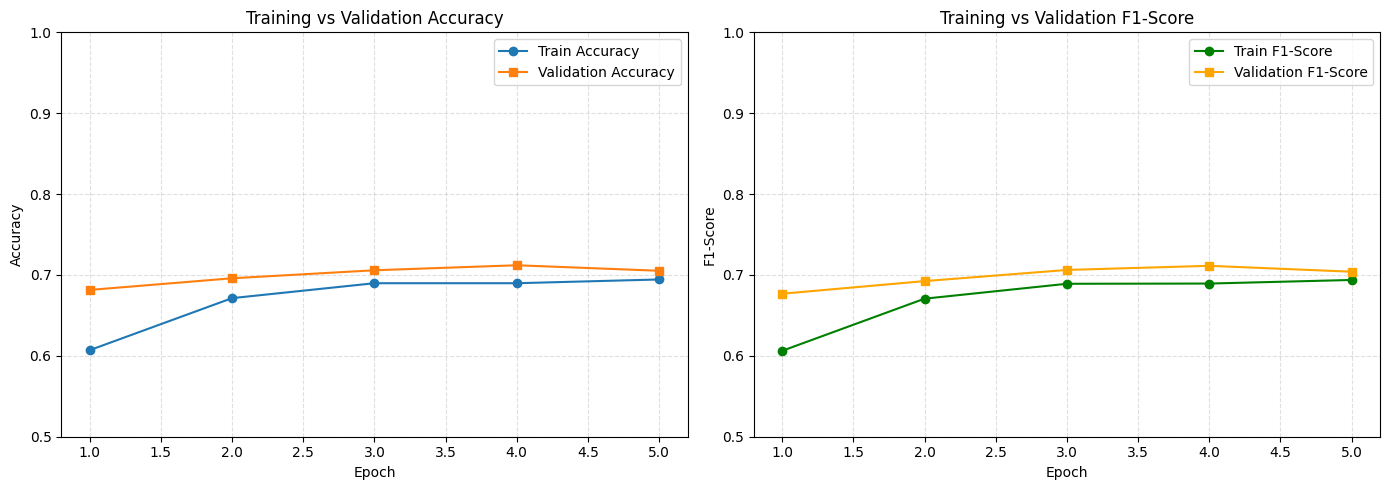

In [6]:
def plot_metrics(history: dict[str, list[float]]):
    """Plot training and validation accuracy and F1-score history."""
    epochs = range(1, len(history.get("train_acc", [])) + 1)
    if not epochs:
        raise ValueError("History is empty; run training before plotting.")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    ax1.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    ax1.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Training vs Validation Accuracy")
    ax1.set_ylim(0.50, 1.0)
    ax1.grid(True, linestyle="--", alpha=0.4)
    ax1.legend()
    
    # F1-score plot
    ax2.plot(epochs, history["train_f1"], label="Train F1-Score", marker="o", color='green')
    ax2.plot(epochs, history["val_f1"], label="Validation F1-Score", marker="s", color='orange')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("F1-Score")
    ax2.set_title("Training vs Validation F1-Score")
    ax2.set_ylim(0.50, 1.0)
    ax2.grid(True, linestyle="--", alpha=0.4)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


plot_metrics(training_history)

In [7]:
def unfreeze_last_blocks(model: nn.Module, num_blocks: int = 2) -> nn.Module:
    """Enable gradient updates for the last few residual blocks and classifier."""
    blocks = list(model.layer4.children())
    if num_blocks > len(blocks):
        raise ValueError(f"Requested {num_blocks} blocks but model.layer4 has only {len(blocks)}")

    for block in blocks[-num_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    for param in model.fc.parameters():
        param.requires_grad = True

    return model


def fine_tune_model(model: nn.Module,
                     dataloaders: dict,
                     epochs: int = 15,
                     lr: float = 1e-5,
                     num_blocks_to_unfreeze: int = 2,
                     patience: int = 5) -> tuple[nn.Module, dict[str, list[float]]]:
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")
    if train_loader is None or val_loader is None:
        raise ValueError("Both 'train' and 'val' splits are required for fine-tuning.")

    device = get_device()
    model = model.to(device)
    model = unfreeze_last_blocks(model, num_blocks=num_blocks_to_unfreeze)

    # Calculate class weights from training data
    from collections import Counter
    train_dataset = train_loader.dataset
    if hasattr(train_dataset, 'dataset'):
        base_dataset = train_dataset.dataset
        indices = train_dataset.indices
        all_labels = [base_dataset.targets[i] for i in indices]
    else:
        all_labels = train_dataset.targets
    
    label_counts = Counter(all_labels)
    total_samples = len(all_labels)
    num_classes = len(label_counts)
    class_weights = torch.tensor([total_samples / (num_classes * label_counts[i]) 
                                   for i in range(num_classes)], dtype=torch.float32).to(device)
    
    print(f"Class weights for fine-tuning: {class_weights.cpu().numpy()}")

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = StepLR(optimizer, step_size=max(epochs // 3, 1), gamma=0.5) if epochs > 1 else None

    history = {"train_loss": [], "train_acc": [], "train_f1": [],
               "val_loss": [], "val_acc": [], "val_f1": []}
    best_weights = copy.deepcopy(model.state_dict())
    best_val_f1 = 0.0
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device, split="val", epoch=epoch, total_epochs=epochs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        if scheduler is not None:
            scheduler.step()

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_weights = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"[Fine-tune] Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f} ✓ [Best]")
        else:
            epochs_no_improve += 1
            print(f"[Fine-tune] Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f} [No improve: {epochs_no_improve}/{patience}]")
            
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs (patience={patience})")
                break

    model.load_state_dict(best_weights)
    print(f"Best validation F1-score after fine-tuning: {best_val_f1:.4f}")

    test_loader = dataloaders.get("test")
    if test_loader is not None:
        test_loss, test_acc, test_f1 = evaluate(model, test_loader, criterion, device, split="test")
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f}")

    return model, history


feature_model, finetune_history = fine_tune_model(feature_model,
                                                  dataloaders,
                                                  epochs=15,
                                                  lr=1e-5,
                                                  num_blocks_to_unfreeze=2,
                                                  patience=5)


Class weights for fine-tuning: [0.99329525 1.0025063  1.0015023  0.99181753 0.9908348  1.0060362
 1.0062894  1.0088272  0.9995003  0.9997501 ]


Train [1/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [1/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 1/15 | Train Loss: 0.7943 Acc: 0.7204 F1: 0.7199 | Val Loss: 0.6615 Acc: 0.7685 F1: 0.7687 ✓ [Best]


Train [2/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [2/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 2/15 | Train Loss: 0.6764 Acc: 0.7645 F1: 0.7643 | Val Loss: 0.5991 Acc: 0.7868 F1: 0.7868 ✓ [Best]


Train [3/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [3/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 3/15 | Train Loss: 0.6240 Acc: 0.7811 F1: 0.7809 | Val Loss: 0.5766 Acc: 0.7957 F1: 0.7957 ✓ [Best]


Train [4/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [4/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 4/15 | Train Loss: 0.5875 Acc: 0.7967 F1: 0.7965 | Val Loss: 0.5441 Acc: 0.8106 F1: 0.8105 ✓ [Best]


Train [5/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [5/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 5/15 | Train Loss: 0.5556 Acc: 0.8059 F1: 0.8057 | Val Loss: 0.5130 Acc: 0.8170 F1: 0.8170 ✓ [Best]


Train [6/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [6/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 6/15 | Train Loss: 0.5267 Acc: 0.8152 F1: 0.8151 | Val Loss: 0.5076 Acc: 0.8208 F1: 0.8205 ✓ [Best]


Train [7/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [7/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 7/15 | Train Loss: 0.5176 Acc: 0.8189 F1: 0.8188 | Val Loss: 0.4992 Acc: 0.8246 F1: 0.8243 ✓ [Best]


Train [8/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [8/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 8/15 | Train Loss: 0.5042 Acc: 0.8240 F1: 0.8239 | Val Loss: 0.4833 Acc: 0.8291 F1: 0.8293 ✓ [Best]


Train [9/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [9/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 9/15 | Train Loss: 0.4916 Acc: 0.8283 F1: 0.8281 | Val Loss: 0.4839 Acc: 0.8315 F1: 0.8307 ✓ [Best]


Train [10/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [10/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 10/15 | Train Loss: 0.4864 Acc: 0.8295 F1: 0.8294 | Val Loss: 0.4799 Acc: 0.8252 F1: 0.8246 [No improve: 1/5]


Train [11/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [11/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 11/15 | Train Loss: 0.4747 Acc: 0.8354 F1: 0.8352 | Val Loss: 0.4682 Acc: 0.8378 F1: 0.8374 ✓ [Best]


Train [12/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [12/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 12/15 | Train Loss: 0.4752 Acc: 0.8335 F1: 0.8334 | Val Loss: 0.4700 Acc: 0.8353 F1: 0.8351 [No improve: 1/5]


Train [13/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [13/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 13/15 | Train Loss: 0.4597 Acc: 0.8405 F1: 0.8403 | Val Loss: 0.4570 Acc: 0.8396 F1: 0.8399 ✓ [Best]


Train [14/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [14/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 14/15 | Train Loss: 0.4623 Acc: 0.8396 F1: 0.8396 | Val Loss: 0.4657 Acc: 0.8362 F1: 0.8362 [No improve: 1/5]


Train [15/15]:   0%|          | 0/1250 [00:00<?, ?it/s]

Val [15/15]:   0%|          | 0/313 [00:00<?, ?it/s]

[Fine-tune] Epoch 15/15 | Train Loss: 0.4499 Acc: 0.8429 F1: 0.8427 | Val Loss: 0.4568 Acc: 0.8362 F1: 0.8360 [No improve: 2/5]
Best validation F1-score after fine-tuning: 0.8399


Test:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2884 Acc: 0.9000 F1: 0.9003


In [8]:
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)
weights_path = artifacts_dir / "resnet34_finetuned_cifar_10.pth"
torch.save(feature_model.state_dict(), weights_path)
print(f"Saved fine-tuned weights to {weights_path}")

Saved fine-tuned weights to artifacts/resnet34_finetuned_cifar_10.pth


Combined epochs: 20 (feature extraction: 5, fine-tuning: 15)


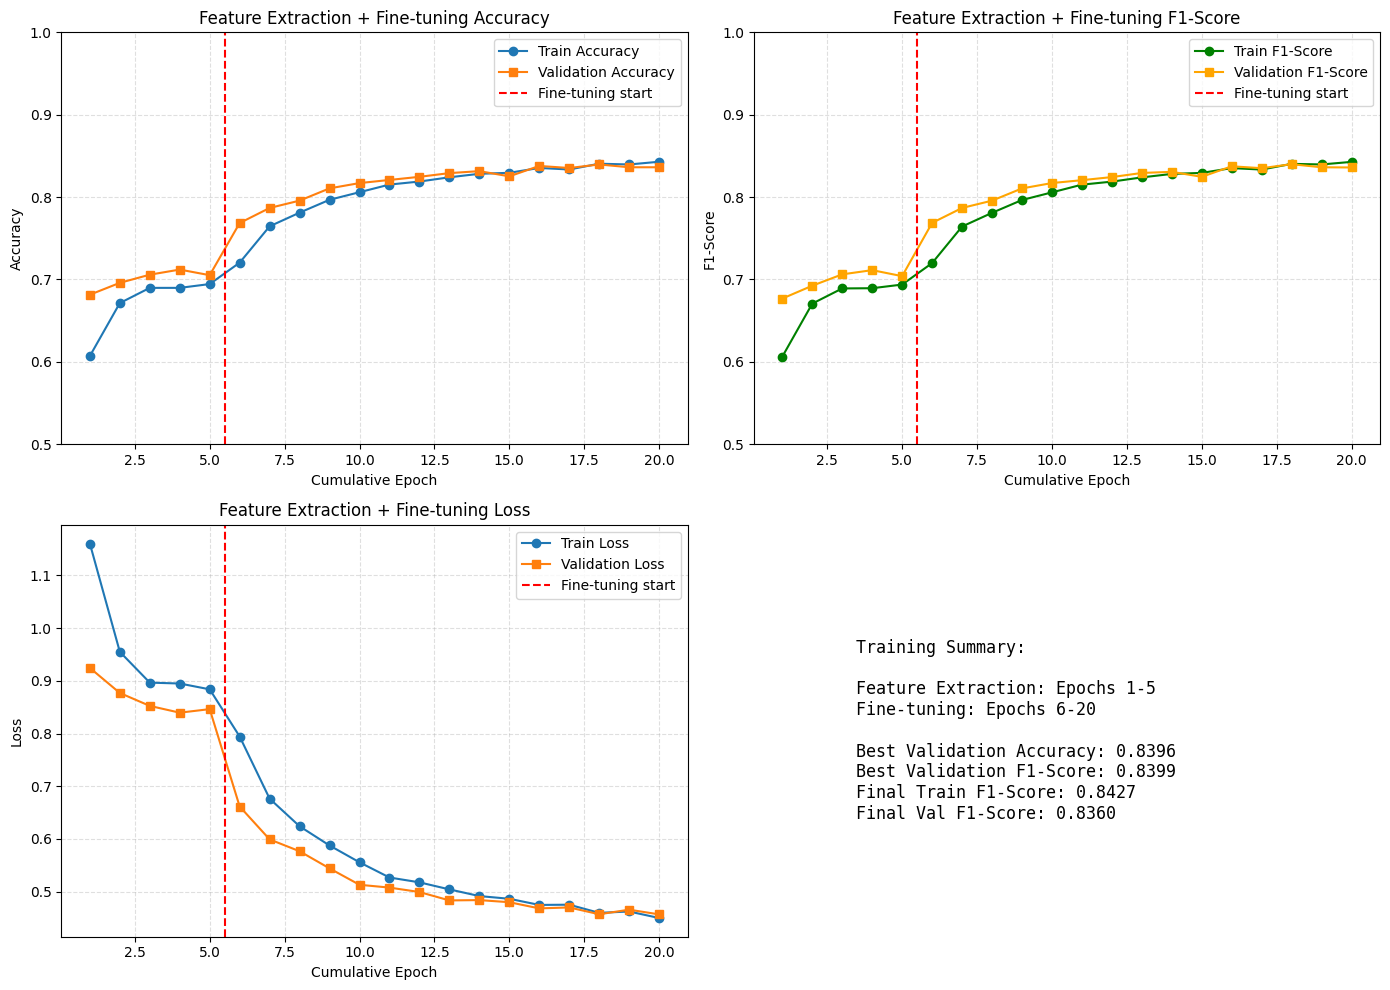

Feature extraction epochs: 1-5
Fine-tuning epochs: 6-20


In [9]:
def combine_histories(initial: dict[str, list[float]], continued: dict[str, list[float]]):
    """Concatenate metric histories from feature extraction and fine-tuning runs."""
    if not initial or not continued:
        raise ValueError("Both initial and continued histories must be provided.")

    combined = {metric: list(initial.get(metric, [])) + list(continued.get(metric, []))
                for metric in set(initial) | set(continued)}

    initial_epochs = len(initial.get("train_acc", []))
    continued_epochs = len(continued.get("train_acc", []))
    epoch_index = np.arange(1, initial_epochs + continued_epochs + 1)

    boundary_epoch = initial_epochs
    return combined, epoch_index, boundary_epoch


def plot_combined_metrics(initial_history: dict[str, list[float]],
                          continued_history: dict[str, list[float]]):
    combined, epoch_index, boundary = combine_histories(initial_history, continued_history)
    max_epochs = min(20, len(epoch_index))
    epoch_index = epoch_index[:max_epochs]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Accuracy plot
    ax1.plot(epoch_index, combined["train_acc"][:max_epochs], label="Train Accuracy", marker="o")
    ax1.plot(epoch_index, combined["val_acc"][:max_epochs], label="Validation Accuracy", marker="s")
    ax1.axvline(boundary + 0.5, color="red", linestyle="--", linewidth=1.5, label="Fine-tuning start")
    ax1.set_xlabel("Cumulative Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Feature Extraction + Fine-tuning Accuracy")
    ax1.set_ylim(0.50, 1.0)
    ax1.grid(True, linestyle="--", alpha=0.4)
    ax1.legend()
    
    # F1-score plot
    ax2.plot(epoch_index, combined["train_f1"][:max_epochs], label="Train F1-Score", marker="o", color='green')
    ax2.plot(epoch_index, combined["val_f1"][:max_epochs], label="Validation F1-Score", marker="s", color='orange')
    ax2.axvline(boundary + 0.5, color="red", linestyle="--", linewidth=1.5, label="Fine-tuning start")
    ax2.set_xlabel("Cumulative Epoch")
    ax2.set_ylabel("F1-Score")
    ax2.set_title("Feature Extraction + Fine-tuning F1-Score")
    ax2.set_ylim(0.50, 1.0)
    ax2.grid(True, linestyle="--", alpha=0.4)
    ax2.legend()
    
    # Loss plot
    ax3.plot(epoch_index, combined["train_loss"][:max_epochs], label="Train Loss", marker="o")
    ax3.plot(epoch_index, combined["val_loss"][:max_epochs], label="Validation Loss", marker="s")
    ax3.axvline(boundary + 0.5, color="red", linestyle="--", linewidth=1.5, label="Fine-tuning start")
    ax3.set_xlabel("Cumulative Epoch")
    ax3.set_ylabel("Loss")
    ax3.set_title("Feature Extraction + Fine-tuning Loss")
    ax3.grid(True, linestyle="--", alpha=0.4)
    ax3.legend()
    
    # Summary text
    ax4.axis('off')
    summary_text = f"""
    Training Summary:
    
    Feature Extraction: Epochs 1-{boundary}
    Fine-tuning: Epochs {boundary + 1}-{len(epoch_index)}
    
    Best Validation Accuracy: {max(combined["val_acc"][:max_epochs]):.4f}
    Best Validation F1-Score: {max(combined["val_f1"][:max_epochs]):.4f}
    Final Train F1-Score: {combined["train_f1"][max_epochs-1]:.4f}
    Final Val F1-Score: {combined["val_f1"][max_epochs-1]:.4f}
    """
    ax4.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
             verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Feature extraction epochs: 1-{boundary}")
    print(f"Fine-tuning epochs: {boundary + 1}-{len(epoch_index)}")


combined_history, combined_epochs, boundary_epoch = combine_histories(training_history, finetune_history)
print(f"Combined epochs: {len(combined_epochs)} (feature extraction: {boundary_epoch}, fine-tuning: {len(combined_epochs) - boundary_epoch})")
plot_combined_metrics(training_history, finetune_history)

Running Model Analysis on Test Set...


Getting predictions:   0%|          | 0/313 [00:00<?, ?it/s]


1. Confusion Matrix Analysis


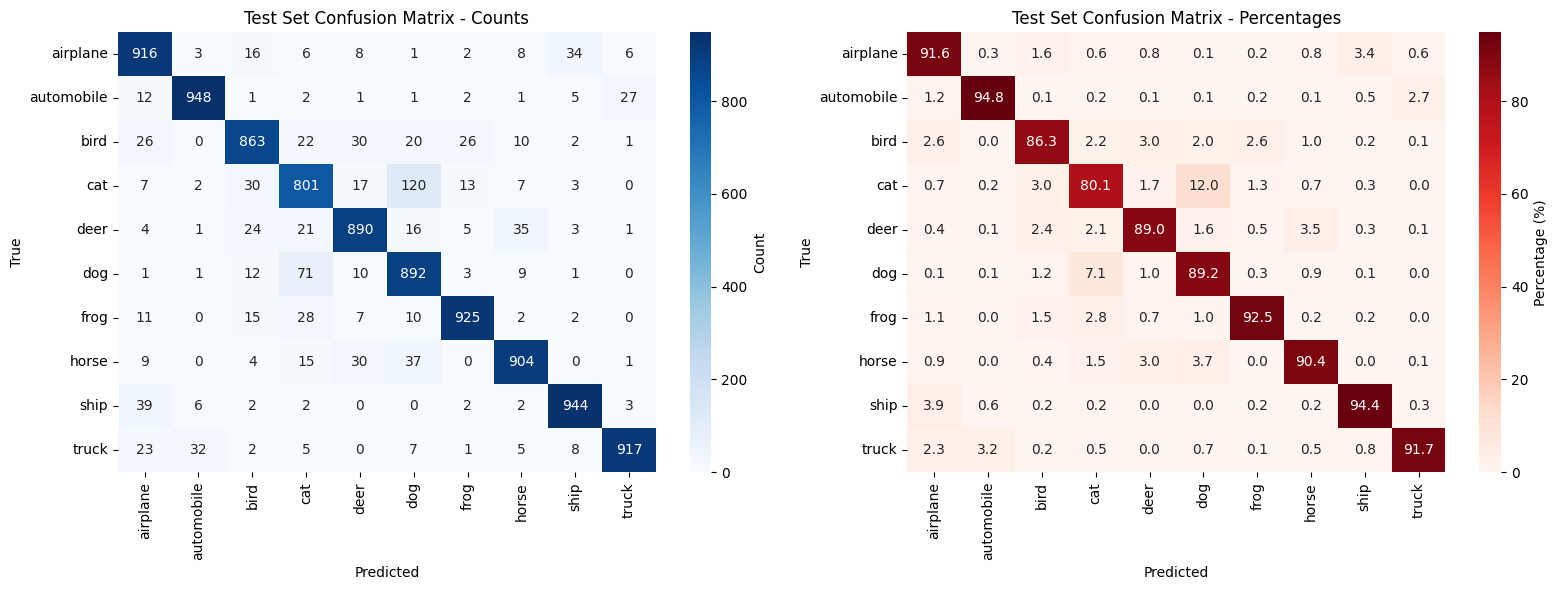


2. Per-Class Performance Metrics


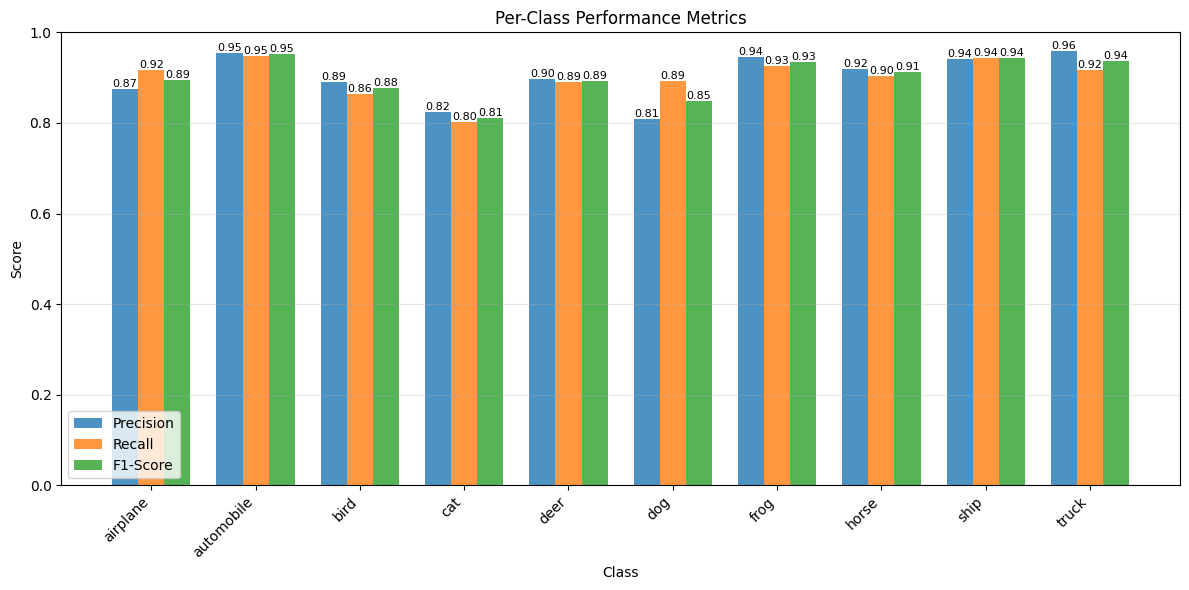


Classification Report:
              precision    recall  f1-score   support

    airplane     0.8740    0.9160    0.8945      1000
  automobile     0.9547    0.9480    0.9513      1000
        bird     0.8906    0.8630    0.8766      1000
         cat     0.8232    0.8010    0.8120      1000
        deer     0.8963    0.8900    0.8931      1000
         dog     0.8080    0.8920    0.8479      1000
        frog     0.9448    0.9250    0.9348      1000
       horse     0.9196    0.9040    0.9117      1000
        ship     0.9421    0.9440    0.9431      1000
       truck     0.9592    0.9170    0.9376      1000

    accuracy                         0.9000     10000
   macro avg     0.9013    0.9000    0.9003     10000
weighted avg     0.9013    0.9000    0.9003     10000


3. Misclassified Examples


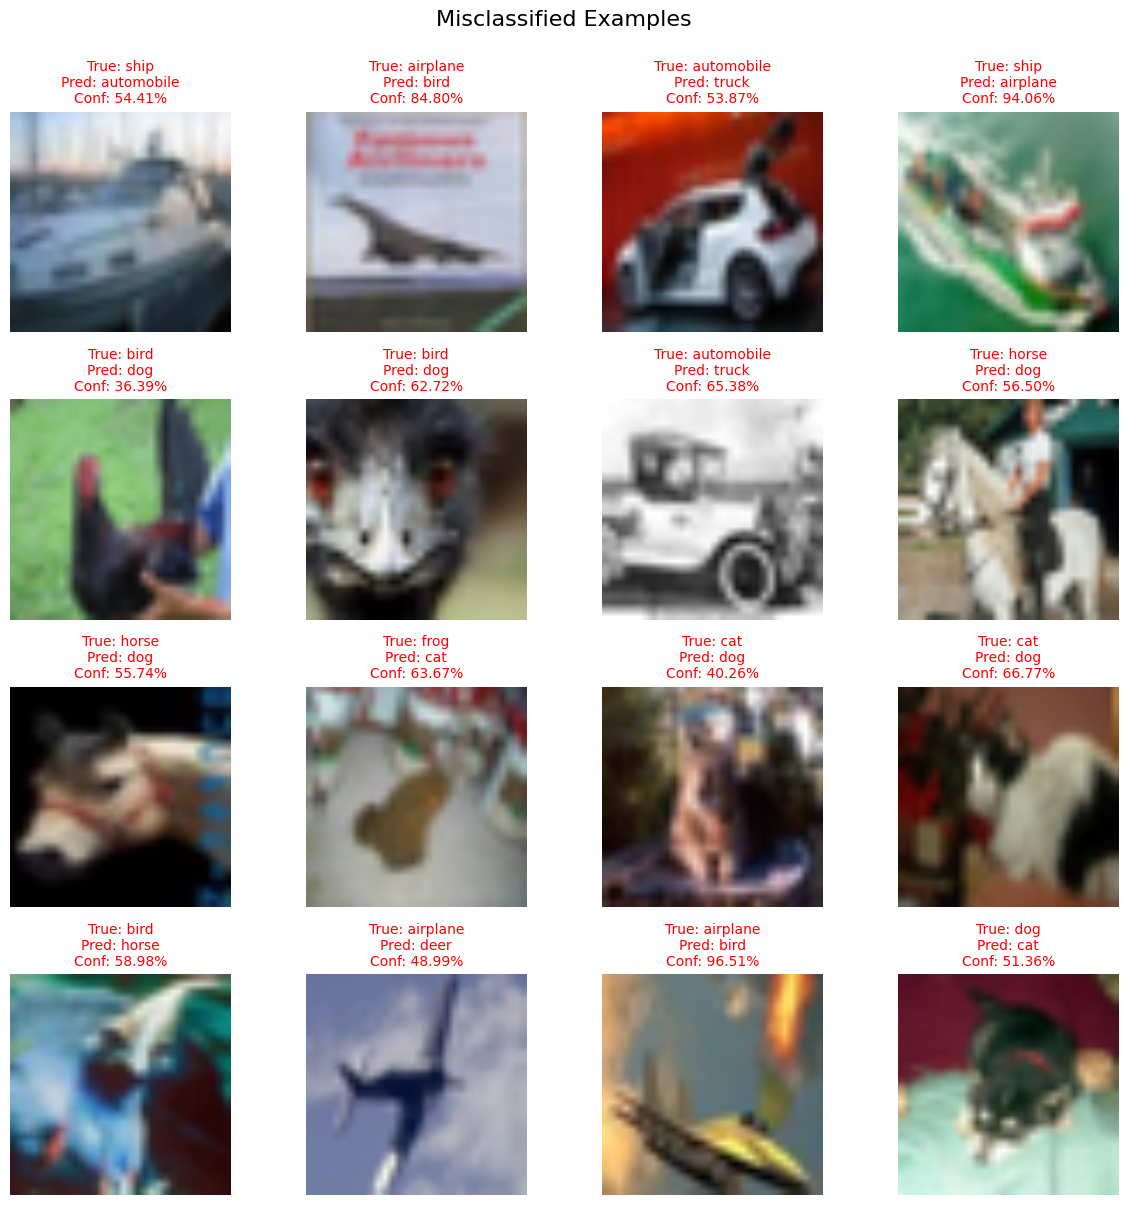


4. Error Pattern Analysis

Top 10 Most Common Misclassifications:
         cat → dog         :  120 samples ( 12.0%)
         dog → cat         :   71 samples (  7.1%)
        ship → airplane    :   39 samples (  3.9%)
       horse → dog         :   37 samples (  3.7%)
        deer → horse       :   35 samples (  3.5%)
    airplane → ship        :   34 samples (  3.4%)
       truck → automobile  :   32 samples (  3.2%)
       horse → deer        :   30 samples (  3.0%)
         cat → bird        :   30 samples (  3.0%)
        bird → deer        :   30 samples (  3.0%)

Confidence Analysis:
Average confidence on correct predictions: 0.9212
Average confidence on errors:              0.6329
Median confidence on correct predictions:  0.9866
Median confidence on errors:               0.6173

Analysis Complete!


In [11]:
# Model Analysis and Evaluation

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_predictions(model: nn.Module, dataloader: DataLoader, device: torch.device):
    """Get all predictions and true labels from a dataloader."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Getting predictions"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)


def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """Plot confusion matrix with percentages."""
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_title(f'{title} - Counts')
    
    # Percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage (%)'}, ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_title(f'{title} - Percentages')
    
    plt.tight_layout()
    plt.show()
    
    return cm


def plot_per_class_metrics(y_true, y_pred, class_names):
    """Plot per-class precision, recall, and F1-score."""
    from sklearn.metrics import precision_recall_fscore_support
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(class_names))
    )
    
    x = np.arange(len(class_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Class')
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.0)
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print("=" * 70)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


def visualize_misclassified(model: nn.Module, dataloader: DataLoader, 
                            class_names: list, device: torch.device,
                            n_images: int = 16):
    """Visualize misclassified images with their predictions."""
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    misclassified_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs_gpu = inputs.to(device)
            outputs = model(inputs_gpu)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            
            # Find misclassified samples in this batch
            mask = preds.cpu() != labels
            if mask.any():
                misclassified_images.extend(inputs[mask])
                misclassified_labels.extend(labels[mask].numpy())
                misclassified_preds.extend(preds[mask].cpu().numpy())
                misclassified_probs.extend(probs[mask].cpu().numpy())
            
            if len(misclassified_images) >= n_images:
                break
    
    if len(misclassified_images) == 0:
        print("No misclassified images found!")
        return
    
    # Limit to requested number
    n_show = min(n_images, len(misclassified_images))
    
    # Denormalize images
    mean = torch.tensor(IMAGENET_MEAN).view(-1, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(-1, 1, 1)
    
    rows = int(np.sqrt(n_show))
    cols = int(np.ceil(n_show / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    
    for idx in range(n_show):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        # Denormalize
        img = misclassified_images[idx] * std + mean
        img = img.permute(1, 2, 0).numpy().clip(0, 1)
        
        true_label = class_names[misclassified_labels[idx]]
        pred_label = class_names[misclassified_preds[idx]]
        confidence = misclassified_probs[idx][misclassified_preds[idx]]
        
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}',
                    fontsize=10, color='red')
    
    # Hide extra subplots
    for idx in range(n_show, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()


def analyze_model_errors(y_true, y_pred, y_probs, class_names):
    """Analyze common error patterns."""
    cm = confusion_matrix(y_true, y_pred)
    
    print("\nTop 10 Most Common Misclassifications:")
    print("=" * 70)
    
    # Find top confusions (excluding diagonal)
    confusions = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusions.append((cm[i, j], class_names[i], class_names[j]))
    
    confusions.sort(reverse=True)
    for count, true_class, pred_class in confusions[:10]:
        total = cm[class_names.index(true_class)].sum()
        percentage = (count / total) * 100
        print(f"{true_class:>12} → {pred_class:<12}: {count:>4} samples ({percentage:>5.1f}%)")
    
    # Analyze confidence on errors
    errors_mask = y_true != y_pred
    if errors_mask.any():
        error_confidences = np.max(y_probs[errors_mask], axis=1)
        correct_confidences = np.max(y_probs[~errors_mask], axis=1)
        
        print(f"\nConfidence Analysis:")
        print("=" * 70)
        print(f"Average confidence on correct predictions: {correct_confidences.mean():.4f}")
        print(f"Average confidence on errors:              {error_confidences.mean():.4f}")
        print(f"Median confidence on correct predictions:  {np.median(correct_confidences):.4f}")
        print(f"Median confidence on errors:               {np.median(error_confidences):.4f}")


# Run comprehensive analysis on test set
print("Running Model Analysis on Test Set...")
print("=" * 70)

device = get_device()
test_loader = dataloaders.get("test")

if test_loader is not None:
    # Get predictions
    y_pred, y_true, y_probs = get_predictions(feature_model, test_loader, device)
    
    # 1. Confusion Matrix
    print("\n1. Confusion Matrix Analysis")
    cm = plot_confusion_matrix(y_true, y_pred, class_names, title="Test Set Confusion Matrix")
    
    # 2. Per-class metrics
    print("\n2. Per-Class Performance Metrics")
    plot_per_class_metrics(y_true, y_pred, class_names)
    
    # 3. Visualize misclassified examples
    print("\n3. Misclassified Examples")
    visualize_misclassified(feature_model, test_loader, class_names, device, n_images=16)
    
    # 4. Error analysis
    print("\n4. Error Pattern Analysis")
    analyze_model_errors(y_true, y_pred, y_probs, class_names)
    
    print("\n" + "=" * 70)
    print("Analysis Complete!")
else:
    print("No test set available for analysis.")